## Install dependencies and setting up GPU Env

In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  18987      0 --:--:-- --:--:-- --:--:-- 18987
OK


In [2]:
!apt-get update & apt-get install tensorflow-model-server

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://pp

In [3]:
!pip install tensorflow-gpu==1.13.1

In [4]:
!pip install requests

## Imports

In [5]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Dataset Preprocessing

load the dataset

In [0]:
(X_train,y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image normalization

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(50000, 32, 32, 3)

## Defining the model
Using 


In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu", input_shape = [32, 32 , 3]))
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation="relu"))
model.add(tf.keras.layers.Dense(units=10, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
__________

## Compiling the model

In [0]:
model.compile(optimizer = 'Adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

### Training model

In [13]:
model.fit(X_train, y_train, batch_size = 128, epochs = 10)

Epoch 1/10
50000/50000 [==============================] - 14s 278us/sample - loss: 1.4912 - sparse_categorical_accuracy: 0.4628
Epoch 2/10
50000/50000 [==============================] - 12s 232us/sample - loss: 1.0351 - sparse_categorical_accuracy: 0.6376
Epoch 3/10
50000/50000 [==============================] - 12s 231us/sample - loss: 0.8523 - sparse_categorical_accuracy: 0.7029
Epoch 4/10
50000/50000 [==============================] - 12s 230us/sample - loss: 0.7375 - sparse_categorical_accuracy: 0.7444
Epoch 5/10
50000/50000 [==============================] - 12s 230us/sample - loss: 0.6444 - sparse_categorical_accuracy: 0.7751
Epoch 6/10
50000/50000 [==============================] - 11s 230us/sample - loss: 0.5579 - sparse_categorical_accuracy: 0.8059
Epoch 7/10
50000/50000 [==============================] - 11s 230us/sample - loss: 0.4872 - sparse_categorical_accuracy: 0.8302
Epoch 8/10
50000/50000 [==============================] - 12s 230us/sample - loss: 0.4153 - sparse_categ

### model evaluation

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 153us/sample - loss: 0.8734 - sparse_categorical_accuracy: 0.7491


In [15]:
print(f"test accuracy : {test_accuracy*100}%")

test accuracy : 74.91000294685364%


## Saving Model for Production

###Creating the directory for the model

In [0]:
MODEL_DIR = "model/"
version = 1

In [17]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Saving the model for the TensorFlow Serving

In [22]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


##Setting up the production environment 

### Exporing the MODEL_DIR to enviornment variables. 

In [0]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

###Running TensorFlow Serving REST API

In [27]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [28]:
!tail server.log

2019-08-10 01:58:52.140426: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /content/model/1
2019-08-10 01:58:52.144183: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-08-10 01:58:52.148143: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-08-10 01:58:52.169722: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-08-10 01:58:52.208864: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 68420 microseconds.
2019-08-10 01:58:52.208967: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-08-10 01:58:52.209082: I tensorflow_serving/core

## Create the first POST request

In [29]:
random_image = np.random.randint(0,len(X_test))
random_image

5496

### Creating the JSON data object

In [0]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [31]:
data

'{"signature_name": "serving_default", "instances": [[[[1.0, 0.984313725490196, 0.8784313725490196], [0.9803921568627451, 0.9647058823529412, 0.8588235294117647], [0.984313725490196, 0.9686274509803922, 0.8627450980392157], [0.984313725490196, 0.9686274509803922, 0.8666666666666667], [0.9803921568627451, 0.9607843137254902, 0.8705882352941177], [0.9764705882352941, 0.9607843137254902, 0.8705882352941177], [0.9764705882352941, 0.9607843137254902, 0.8666666666666667], [0.9803921568627451, 0.9607843137254902, 0.8705882352941177], [0.9686274509803922, 0.9529411764705882, 0.8588235294117647], [0.9686274509803922, 0.9490196078431372, 0.8588235294117647], [0.9803921568627451, 0.9607843137254902, 0.8745098039215686], [0.984313725490196, 0.9647058823529412, 0.8784313725490196], [0.9803921568627451, 0.9607843137254902, 0.8823529411764706], [0.9803921568627451, 0.9647058823529412, 0.8784313725490196], [0.984313725490196, 0.9686274509803922, 0.8666666666666667], [0.9803921568627451, 0.964705882352

Sending the first POST request to the model

In [0]:
headers = {"content-type":"application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data=data, headers = headers)

In [39]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [0]:
predictions

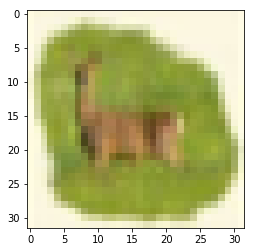

In [41]:
plt.imshow(X_test[random_image])

In [42]:
predictions

[[1.61403179e-07,
  1.01464093e-06,
  0.00240701158,
  0.0925114751,
  0.338968158,
  0.00175551232,
  0.564325273,
  2.47274547e-05,
  8.18497369e-07,
  5.76138336e-06]]

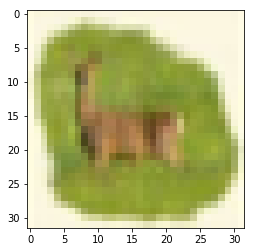

In [46]:
plt.imshow(X_test[random_image])

In [47]:
class_names[np.argmax(predictions[0])]

'frog'

## Sending POST request to a specific model

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/model/cifar10/versions/1:predict",data=data,headers=headers)

In [49]:
specific_json_response

<Response [400]>